# Predictive Data Analysis

In this phase, we will explore the use of Keras, assisted with the use of Google's Teachable Machine, to ascertain whether or not a logo may be counterfeit.

First, Colab's Google Drive integration will be configured.

# Setup
**NOTE**: If you're running this notebook from your own Colab account, or not running it from Colab, you will need to edit the following cell or failure will occur.
This cell assumes that the dataset is in a folder called "capstone" at the root of the user's Drive account, and that Drive is mounted at `/content/drive`.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_path = "/content/drive/MyDrive/capstone/dataset"
genuine_logos = base_path + "/output/"
counterfeit_logos = base_path + "/genLogoOutput/"

!pip3 install Pillow tensorflow

Mounted at /content/drive


# Dataset Preparation

The Teachable Machine web interface allows you to upload multiple files, but the dataset stores these in separate folders with subfolders, making uploading cumbersome and error-prone.

Hence, the mapping file will be used to separate genuine and counterfeit logos into two flat folders, ready for bulk selection in the web interface.

**WARNING: THE CELLS IN THIS SECTION WILL WRITE FILES TO GOOGLE DRIVE WHEN EXECUTED.**

First, the two folders, representing the two different image classes, are created:

In [ ]:
# Define the output paths for training data
genuine_training_path = "/content/drive/MyDrive/capstone/training/genuine"
counterfeit_training_path = "/content/drive/MyDrive/capstone/training/fake"

# Create the training output directories, deleting them if they exist already
# (i.e, due to a mistake resulting in an incomplete copy)
import os, shutil
shutil.rmtree(genuine_training_path, ignore_errors=True)
shutil.rmtree(counterfeit_training_path, ignore_errors=True)
os.makedirs(genuine_training_path)
os.makedirs(counterfeit_training_path)

Next, we load the mapping file as a Pandas dataframe. This file contains the label (specifying the image class) and image path for each logo in the dataset.

This label will be used to determine which folder the image is copied into.

Then, each row in the dataframe is iterated over, consulting the label field to determine the target directory and the file path column to be used as the copy source.

**NOTE:** The author appears to have prepared this file on a Windows system, meaning that backslashes have been used as directory separators. As Colab is a Linux environment, these must be converted to forward slashes. Comment the string replace operation under the declaration of `relative_path` if you encounter errors.

Python's built-in file copy mechanism is then used to copy the file into the directory.

**The following cell may take a long time (minutes) to execute within Colab.**

In [ ]:
import pandas as pd

dataframe = pd.read_csv(base_path + "/file_mapping.csv")
copied = 0

for index, row in dataframe.iterrows():
  label = row["Label"]
  relative_path = row["Filename"]

  # Comment this out if running on Windows (outside of Colab), or errors may occur.
  relative_path = relative_path.replace("\\", "/")

  if label == "Genuine":
    output_folder = genuine_training_path
  elif label == "Fake":
    output_folder = counterfeit_training_path

  source = base_path + "/" + relative_path
  target = output_folder + f"/{copied}.jpg"
  #print(f"Copying {source} to {target}")
  shutil.copy(source, target)
  copied += 1

print(f"{copied} files copied.")

825 files copied.


# Training with Teachable Machine

After separating the two classes of image into two separate folders, the Teachable Machine web interface is used to train a neural network for image classification.

The output of this step is a Keras model, ready for use in inferencing.

# Testing the Model

In [2]:
import matplotlib.pyplot as plot
%matplotlib inline

from keras.models import load_model  # TensorFlow is required for Keras to work
from PIL import Image, ImageOps  # Install pillow instead of PIL
import numpy as np

def infer(img):
  # This function is a modified version of Teachable Machine's Keras export snippet.
  # Google Inc, (no date), Teachable Machine. https://teachablemachine.withgoogle.com/

  # Disable scientific notation for clarity
  np.set_printoptions(suppress=True)

  # Load the model
  model = load_model("/content/drive/MyDrive/capstone/keras_model.h5", compile=False)

  # Load the labels
  class_names = open("/content/drive/MyDrive/capstone/labels.txt", "r").readlines()

  # Create the array of the right shape to feed into the keras model
  # The 'length' or number of images you can put into the array is
  # determined by the first position in the shape tuple, in this case 1
  data = np.ndarray(shape=(1, 224, 224, 3), dtype=np.float32)

  # Replace this with the path to your image
  image = Image.open(img).convert("RGB")

  # resizing the image to be at least 224x224 and then cropping from the center
  size = (224, 224)
  image = ImageOps.fit(image, size, Image.Resampling.LANCZOS)

  # turn the image into a numpy array
  image_array = np.asarray(image)

  # Normalize the image
  normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

  # Load the image into the array
  data[0] = normalized_image_array

  # Predicts the model
  prediction = model.predict(data)
  index = np.argmax(prediction)
  class_name = class_names[index]
  confidence_score = prediction[0][index]

  # Print prediction and confidence score
  print("Class:", class_name[2:], end="")
  print("Confidence Score:", confidence_score)
  plot.figure(figsize=(2, 2))
  plot.imshow(image)


1/1 [==============================] - 1s 937ms/step
Class: Genuine
Confidence Score: 0.9999924


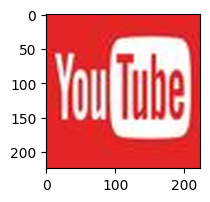

In [3]:
infer("/content/drive/MyDrive/capstone/dataset/output/YouTube/000001.jpg")

1/1 [==============================] - 1s 784ms/step
Class: Fake
Confidence Score: 1.0


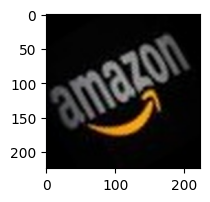

In [4]:
infer("/content/drive/MyDrive/capstone/dataset/genLogoOutput/Amazon/000003.jpg")